In [36]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

In [2]:
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from detection import rnn_detection as rnn_det
from detection import bls_detection as bls_det
from simulations import lightcurve_simulation as lcsim
import visualize as vis

from dataloading import loading as dl

from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

from wotan import flatten

In [3]:
# fnames = [fnm for fnm in os.listdir("data/eval/sim/singleplanet") if not fnm.startswith(".")]

# window_lengths = [0.25, 0.5, 1.0]  # days

# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         bls_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         time = np.arange(len(batch["flux"][0]))*utils.min2day(2)
#         for i in range(len(batch["flux"])):
#             sampleid = int(batch["sampleid"][i])
#             bls_detections[sampleid] = {}
#             for wl in window_lengths:
#                 flat = flatten(time, batch["flux"][i], method="median", window_length=wl)
#                 detected = bls_det.algorithm(time, flat, num_iters=3)
#                 bls_detections[sampleid][wl] = detected
#         with open("results/bls_singles/"+fname, "wb") as f:
#             pickle.dump(bls_detections, f)
            
#     except:
#         pbar.close()
#         raise

In [4]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/bls_singles") if not fname.startswith(".")]:
#     with open("results/bls_singles/"+fnm, "rb") as f:
#         bls_det_batch = pickle.load(f)
#         detections = {**detections, **bls_det_batch}
# with open("results/bls_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

In [5]:
# rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

In [6]:
# mean, std = -0.10192371859533564, 2.6337997430623323  # obtained from training set
# fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]

# rnn_.to("cpu")


# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         rnn_detections = {}
#         batch = dl.load_data("data/eval/sim/singleplanet/"+fname)
#         if batch is None:
#             continue
#         sigma = np.array([batch["meta"][i]["sigma"] for i in batch["sampleid"]])
#         flux_ = ((batch["flux"]-1) / sigma[:,None] - mean) / std
  
#         flux_in = flux_.reshape(-1,flux_.shape[-1])
#         pts_ = np.zeros_like(flux_in)

#         step = 50
#         for i in range(step, len(flux_in)+1, step):
#             pts_[i-step:i] = rnn_det.get_pts(rnn_, flux_in[i-step:i], additional=False)
#             rnn_.to("cpu")

#         for i, sampleid in enumerate(batch["sampleid"]):
#             detected1 = rnn_det.algorithm1(pts_[i].copy(), num_iters=3, min_transits=3, p_min=2, p_max=None, step_mult=2, 
#                smooth=True, peak_frac=2, show_steps=False)
            
#             detected2 = rnn_det.algorithm2(pts_[i], None, num_iters=3, smooth=True, p_min=2)

#             rnn_detections[sampleid] = {"rnn1":detected1,
#                                         "rnn2":detected2}
#         with open("results/rnn_singles/"+fname, "wb") as f:
#             pickle.dump(rnn_detections, f)                       

#     except:
#         pbar.close()
#         raise

In [7]:
# detections = {}
# for fnm in [fnm for fnm in os.listdir("results/rnn_singles") if not fname.startswith(".")]:
#     with open("results/rnn_singles/"+fnm, "rb") as f:
#         rnn_det_batch = pickle.load(f)
#         detections = {**detections, **rnn_det_batch}
# with open("results/rnn_single_detections.pkl", "wb") as f:
#     pickle.dump(detections, f)

## Results

In [30]:
def correct_detection(params, detection, dur_factor=1, per_frac=0.01):
    # assumes sample (params) contains single planet 
    if params["planets"] == {}:
        print("sample contains no planets")
        raise Exception
    t0_true = params["planets"][0]["pl_t0"]
    dur_true = params["planets"][0]["pl_duration"]
    per_true = params["planets"][0]["pl_period"]
    t0_correct = (detection["t0"] > (t0_true - 0.5*dur_factor*dur_true)) and \
                 (detection["t0"] < (t0_true + 0.5*dur_factor*dur_true))
    per_correct = (1-per_frac)*per_true < detection["period"] and detection["period"] < (1+per_frac)*per_true
    correct = (t0_correct and per_correct)
    return correct

def get_data_params(load_dir="data/eval/sim/singleplanet"):
    meta = {}
    fnames = [fnm for fnm in os.listdir(load_dir) if not fnm.startswith(".")]
    for fname in fnames:
        batch = dl.load_data(load_dir + "/"+fname)
        if batch is None:
            continue
        meta = {**meta, **batch["meta"]}
    return meta

def get_results(load_pkl, best_only=False):
    with open(load_pkl, "rb") as f:
        detections = pickle.load(f)
    if best_only:
        for i in detections:
            for mname in detections[i]:
                if len(list(detections[i][mname].keys())):
                    mx = np.max(list(detections[i][mname].keys()))
                    detections[i][mname] = {mx:detections[i][mname][mx]}
    return detections


def evaluate_thresholds(detections, thresholds):
    snames = ["tp", "fp", "fn", "tn"]
    results = {mname:{sname:[] for sname in snames} for mname in detections[0]}
    pbar = tqdm(thresholds)
    for thr in pbar:  
        try:
            for mname in detections[0]:
                dic = results[mname]
                tp = fp = tn = fn = 0
                for i in meta:
                    contains_planet = len(meta[i]["planets"]) > 0
                    found_planet = False
                    for score, det in detections[i][mname].items():
                        if score >= thr:
                            if contains_planet > 0 and correct_detection(meta[i], det):
                                tp += 1
                                found_planet = True 
                            else:  # no planets in lc or false detection
                                fp += 1
                    if contains_planet and not found_planet:
                        fn += 1
                    # true negative is always inf
                results[mname]["tp"].append(tp), results[mname]["fp"].append(fp) 
                results[mname]["tn"].append(tn), results[mname]["fn"].append(fn) 
        except:
            pbar.close()
            raise
    for mname in detections[0]:
        for sname in snames:
            results[mname][sname] = np.array(results[mname][sname])
    return results


def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"])

def get_recall(dic):
    return get_tpr(dic)

def get_precision(dic):
    return dic["tp"] / (dic["tp"] + dic["fp"]) 

In [19]:
meta = get_data_params()
bls_detections = get_results("results/bls_single_detections.pkl")
rnn_detections = get_results("results/rnn_single_detections.pkl")
rnn_sde_detections = get_results("results/rnn_sde_single_detections.pkl")

In [25]:
bls_results = evaluate_thresholds(bls_detections, np.linspace(0,20,50))

100%|██████████| 50/50 [00:01<00:00, 25.41it/s]


In [26]:
rnn_results = evaluate_thresholds(rnn_detections, np.linspace(0,3,50))

100%|██████████| 50/50 [00:03<00:00, 12.77it/s]


In [27]:
rnn_sde_results = evaluate_thresholds(rnn_sde_detections, np.linspace(0,10,50))

100%|██████████| 50/50 [00:00<00:00, 77.98it/s]


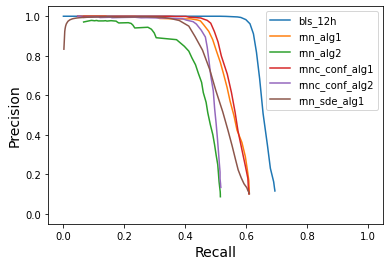

In [41]:
dontshow=[]
onlyshow=["rnnc_conf_alg1", "rnn_alg1", "rnnc_conf_alg2", "rnn_alg2", "bls_12h", "rnn_sde_alg1"]
# onlyshow=["rnn_sde_alg1"]
combined_results = {**bls_results, **rnn_results, **rnn_sde_results}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for mname, dic in combined_results.items():
        if len(onlyshow)>0:
            if mname in onlyshow:
    #             plt.plot(dic["fp"], dic["tp"], label=mname)
                plt.plot(get_recall(dic), get_precision(dic), label=mname)
        elif mname not in dontshow:
    #         plt.plot(dic["fp"], dic["tp"], label=mname)
            plt.plot(get_recall(dic), get_precision(dic), label=mname)
plt.legend(), plt.xlim(-0.05,1.05), plt.ylim(-0.05,1.05)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()